In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

import json
import requests
from IPython.display import display, HTML
import time

In [2]:
print(sc.__version__)

1.5.1


In [3]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [4]:
prefix = '/data/xyzeq/'

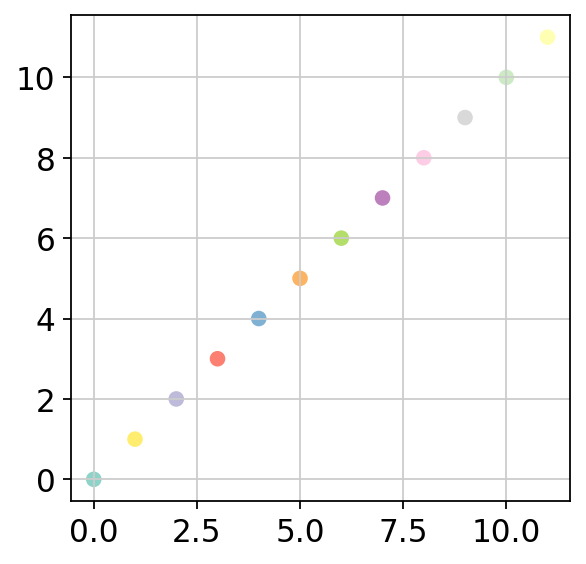

In [5]:
plt.scatter(np.arange(12), np.arange(12), c=['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3'])
colors = dict(zip(['turq','dark yel','light purp','coral','blue','orange','light gr','purp','pink','gray','mint','light yel'],
                  ['#8DD3C7', '#FFED6F', '#BEBADA', '#FB8072', '#80B1D3', '#FDB462', '#B3DE69', '#BC80BD', '#FCCDE5', '#D9D9D9', '#CCEBC5', '#FFFFB3']))

# Load in the Datasets

### Load in the XYZeq data

In [6]:
l20c1raw_prefix = prefix + 'xyzeq/individual.raw.and.proc.h5ads/fig3.L20C1/'
l20c1_prefix = prefix + 'xyzeq/individual.raw.and.proc.h5ads/20200324/'
l20c1_raw = sc.read_h5ad(l20c1raw_prefix + 'adata.1.h5ad')
l20c1 = sc.read_loom(l20c1_prefix + 'L20C1_mouse_wTSNE.loom')

/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/loompy/loom_validator.py:48: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(path) as f:


In [7]:
new_names = list()
for i in l20c1.var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
l20c1.var_names = new_names

... storing 'CellType' as categorical
... storing 'barcode' as categorical
... storing 'cell_call' as categorical
... storing 'leiden' as categorical
... storing 'louvain' as categorical


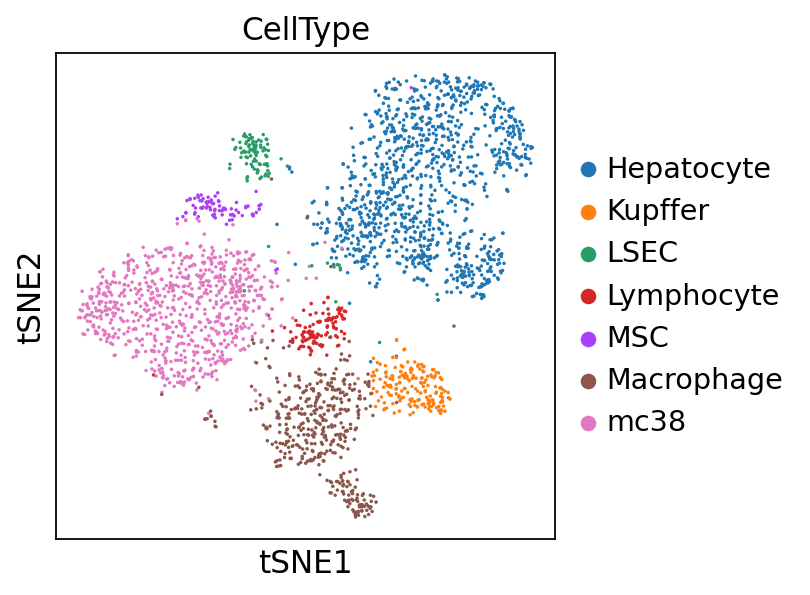

In [8]:
sc.pl.tsne(l20c1,color=['CellType'], size=10)

In [341]:
ctdict = dict()

ctdict['Hepatocytes'] = ['Hepatocyte']
ctdict['Macrophages'] = ['Macrophage']
ctdict['Lymphocytes'] = ['Lymphocyte']
ctdict['LSECs'] = ['LSEC']
ctdict['Kupffer cells'] = ['Kupffer']
ctdict['MSCs'] = ['MSC']
ctdict['MC38'] = ['mc38']

for ct in ctdict:
    for clust in ctdict[ct]:
        l20c1.obs['CellType'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)
# adata.obs['celltypes'] = [i.strip('ct') for i in adata.obs['celltype'].astype('category')]

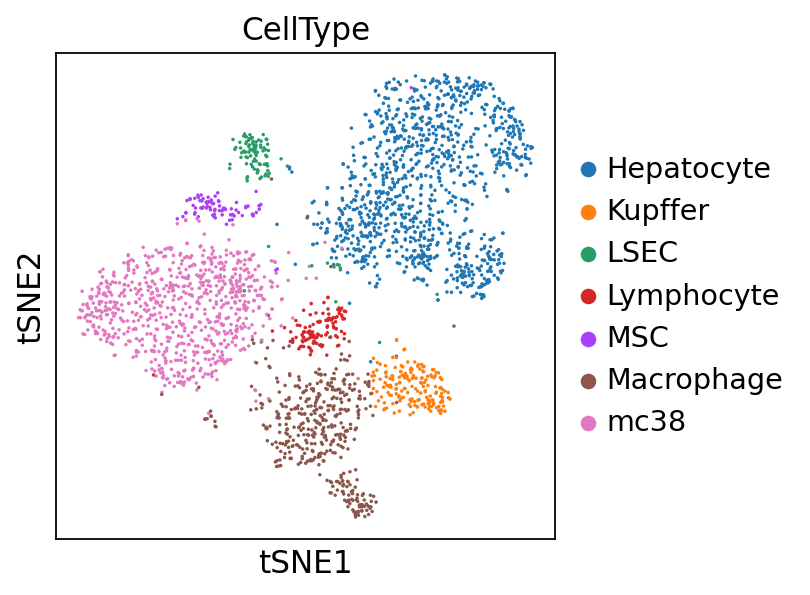

In [9]:
sc.pl.tsne(l20c1,color=['CellType'], size=10)

In [10]:
l20c1.uns['CellType_colors'] = [
    colors['coral'],
    colors['orange'],
    colors['blue'], 
    colors['purp'],
    colors['dark yel'],
    colors['turq'],
    colors['mint']

]

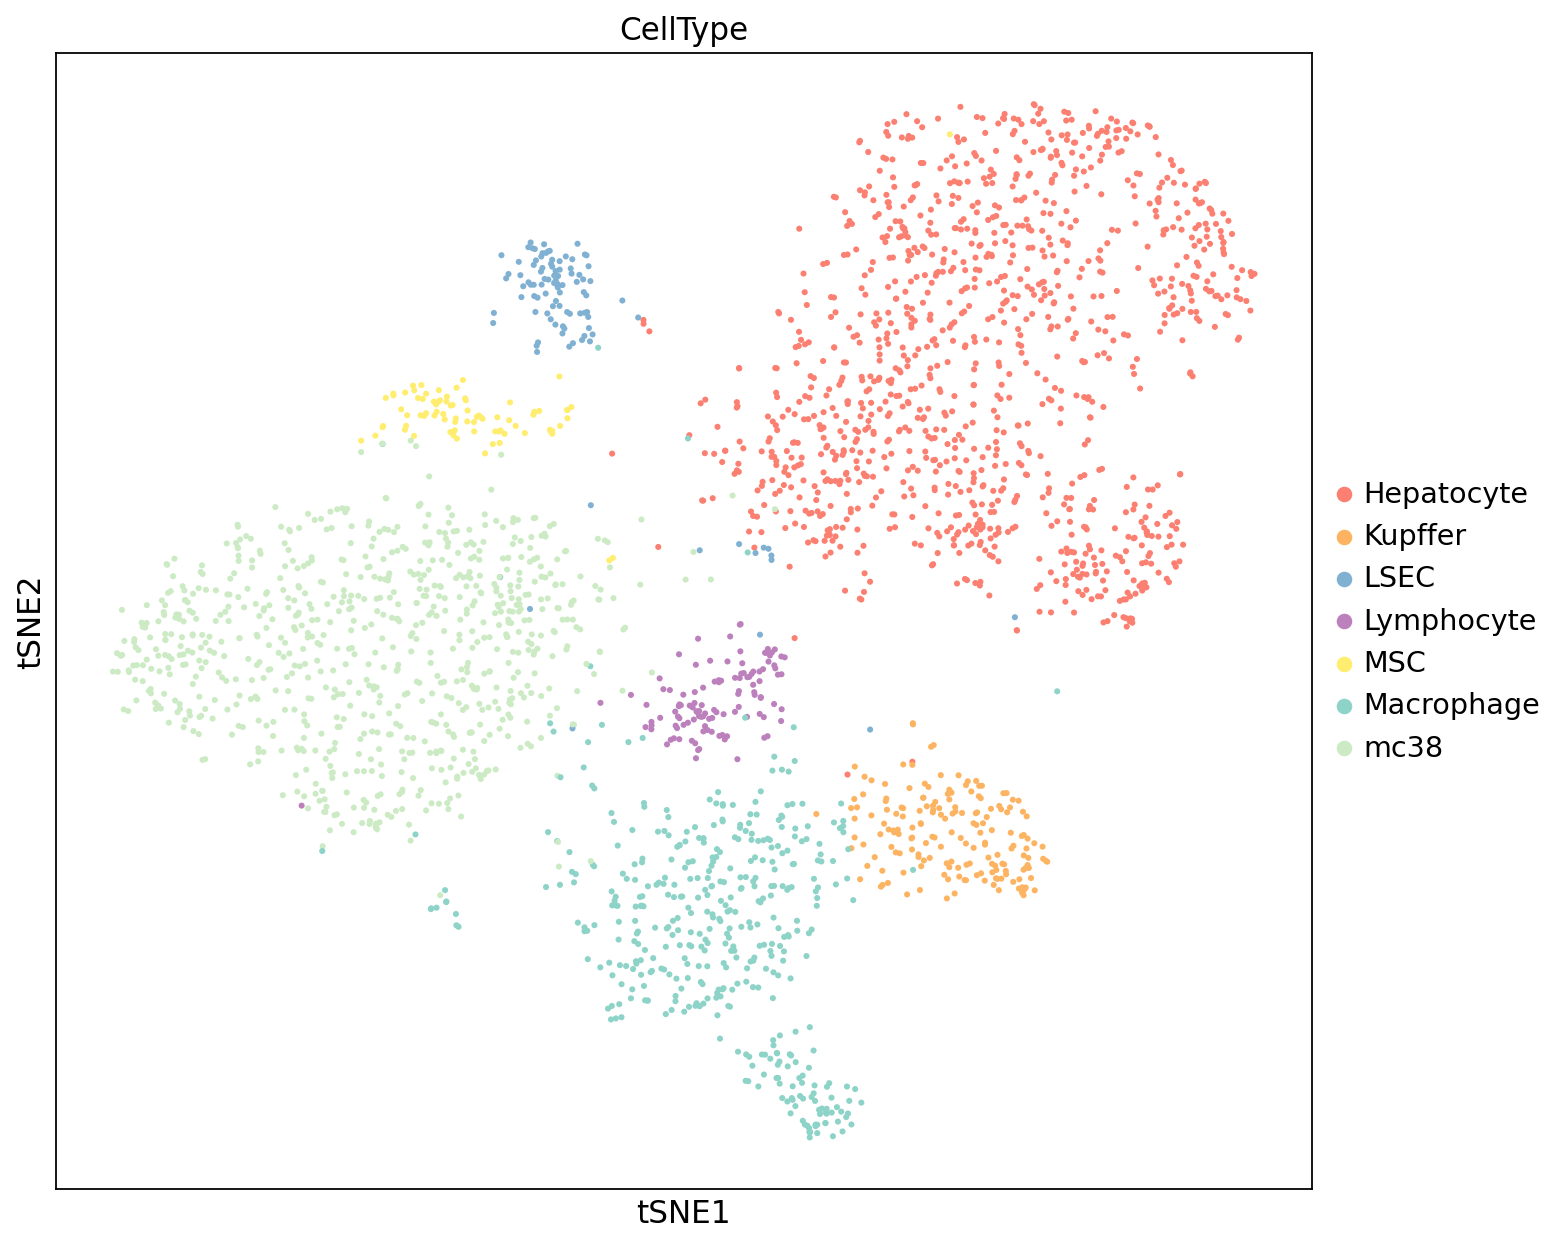

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10, 8))
sc.pl.tsne(l20c1,color=['CellType'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
# plt.savefig(prefix + '10x/2020112/figures2/XYZeq.umap.pdf')

### Load in the 10x data

In [12]:
data = dict()
data['adata_original'] = sc.read_10x_h5(prefix + '10x/5prime_liver/outs/raw_feature_bc_matrix.h5').copy()
data['adata_original'].var_names_make_unique()

data['adata'] = sc.read_h5ad(prefix + '/10x/5prime_liver/20200112/20200112_2.h5ad') # use the one Derek created
# data['adata'] = sc.read_h5ad(prefix + '10x/5prime_liver/20200112/20200112_2.recreated.h5ad') # use the one I recreated from Derek's HTML

data['adata_raw'] = data['adata'].raw._adata.copy()

reading /data/xyzeq/10x/5prime_liver/outs/raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/ssm-user/anaconda3/envs/xyzeq/lib/python3.6/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [13]:
data['adata_original'].shape

(737280, 64591)

In [14]:
new_names = list()
for i in data['adata'].var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata'].var_names = new_names

In [15]:
new_names = list()
for i in data['adata_original'].var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata_original'].var_names = new_names

In [16]:
new_names = list()
for i in data['adata'].raw._var.index:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
data['adata'].raw._var.index = new_names

In [17]:
data['adata'].var_names

Index(['H_RHOB', 'H_CCDC58', 'H_GMPS', 'H_NSUN2', 'H_LMNB1', 'H_HIST1H1C',
       'H_HIST1H1E', 'H_NEFM', 'H_NEFL', 'H_SDCBP',
       ...
       'm_Pank1', 'm_Rbp4', 'm_Cyp2c29', 'm_Cyp2c50', 'm_Cyp2c23', 'm_Elovl3',
       'm_As3mt', 'm_Dusp5', 'm_Bbip1', 'm_Zdhhc6'],
      dtype='object', length=679)

In [18]:
common_genes = np.intersect1d(l20c1.var_names.values, data['adata'].var_names.values)

In [19]:
# data['adata'] = data['adata'][:,common_genes].copy()

In [20]:
sc.pp.pca(data['adata'],n_comps=50)
sc.pp.neighbors(data['adata'],n_neighbors=15, n_pcs=12)
sc.tl.umap(data['adata'], alpha=2)
sc.tl.leiden(data['adata'], resolution=1)

computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 12
    computed neighbors (0:00:00)
    computed connectivities (0:00:04)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
    finished: added
    

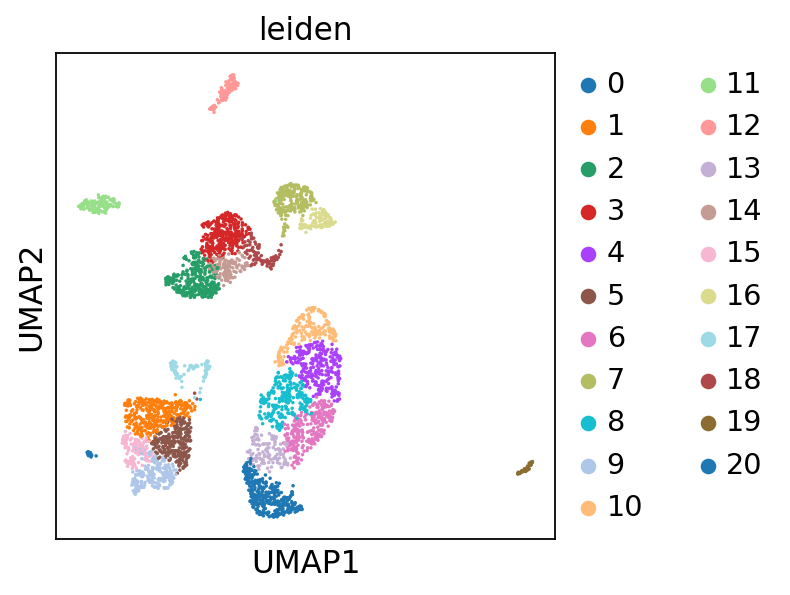

In [21]:
sc.pl.umap(data['adata'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20)

In [22]:
groupings = [[1, 5, 9, 15],
             [0, 4, 6, 8, 10, 13],
             [2, 3, 14, 18],
             [7, 16]
             ]

# groupings = [[5, 7, 8, 9, 10, 12, 13],
#              [1, 4, 6],
#              [0, 3, 17],
#              ]

# groupings = [[0, 4, 5, 9, 10, 14],
#              [1, 6, 8, 15],
#              [2, 3, 13, 18],
#              [7, 12]
#             ]
grouped_clusts = [i for j in groupings for i in j]
numclusts = np.unique(data['adata'].obs['leiden'].values.astype(int))
for i in np.setdiff1d(numclusts, grouped_clusts):
    groupings.append([i])

In [25]:
ctdict = dict()
for i in range(len(groupings)):
    ctdict['ct%s' % str(i)] = groupings[i]

data['adata'].obs['CellType'] = data['adata'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['adata'].obs['CellType'].replace(str(clust), ct, regex=True, inplace=True)
data['adata'].obs['leiden'] = [i.strip('ct') for i in data['adata'].obs['CellType'].astype('category')]

... storing 'leiden' as categorical


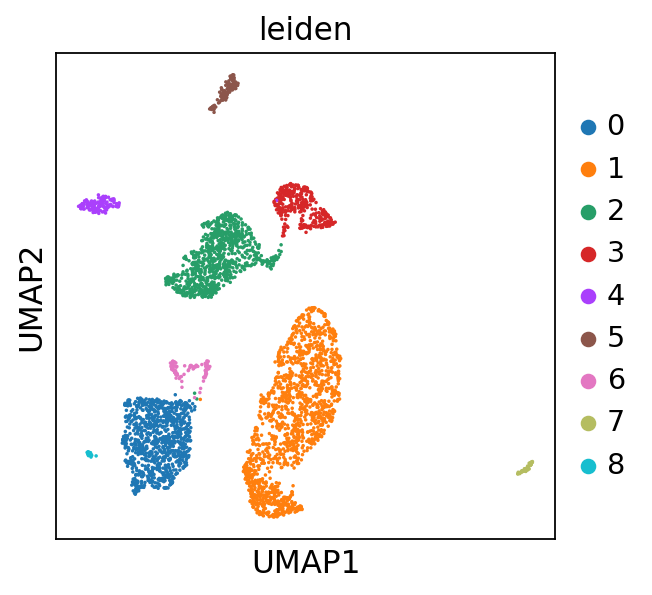

In [26]:
sc.pl.umap(data['adata'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20)

In [37]:
ctdict = dict()
ctdict['HEK293T'] = [0]
ctdict['Hepatocytes'] = [1]
ctdict['MC38'] = [2]
ctdict['Macrophages'] = [3]
ctdict['B cells'] = [5]
ctdict['Kupffer cells'] = [7]
ctdict['LSECs'] = [6]
ctdict['Granulocytes'] = [8]
ctdict['T cells'] = [4]
data['adata'].obs['CellType'] = data['adata'].obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        data['adata'].obs['CellType'].replace(str(clust),ct,regex=True, inplace=True)
data['adata'].obs['CellType'] = data['adata'].obs['CellType'].astype(str)

In [38]:
data['adata'].uns['CellType_colors'] = [
    colors['light gr'],
    colors['pink'],
    colors['gray'],
    colors['coral'],
    colors['orange'],
    colors['blue'],
    colors['dark yel'],
    colors['mint'],
    colors['purp'],
]

... storing 'CellType' as categorical


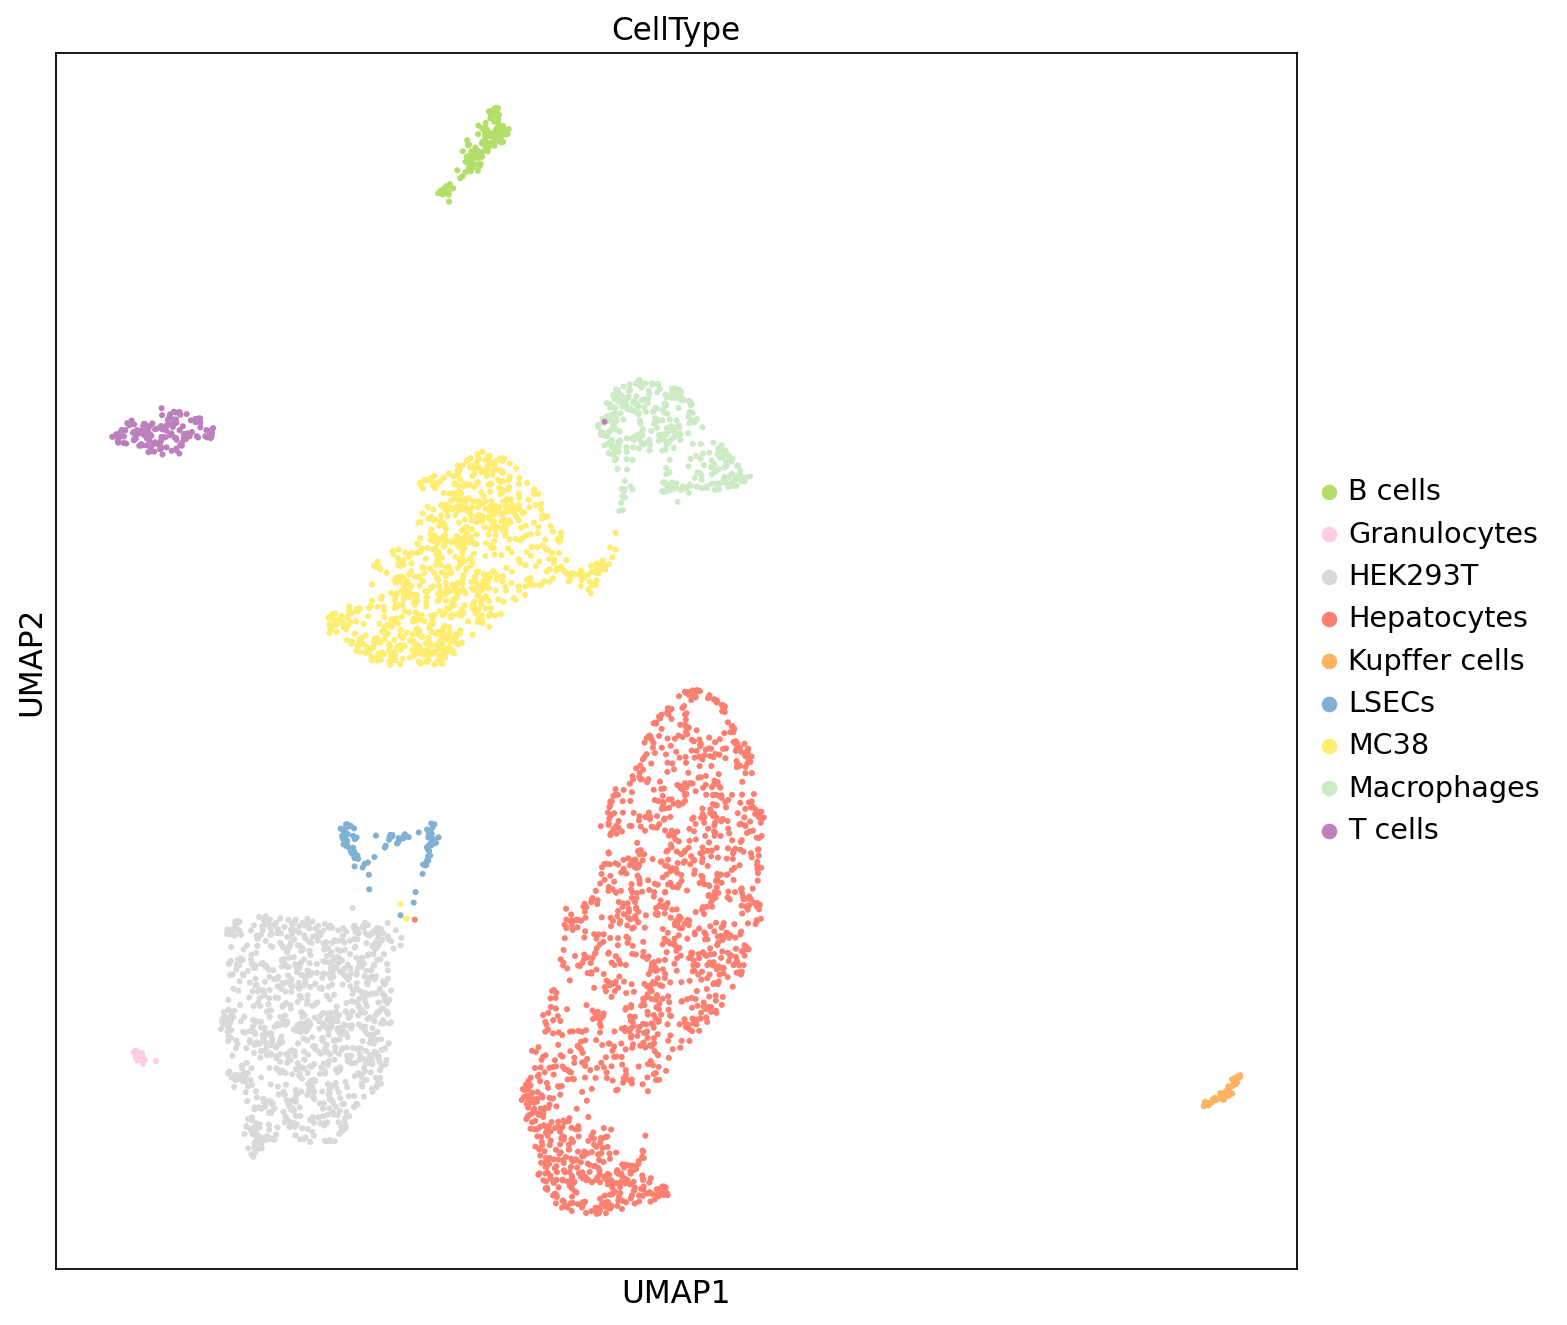

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10, 8.5))
sc.pl.umap(data['adata'],color=['CellType'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
# plt.savefig(prefix + '10x/2020112/figures2/10x.umap.pdf')

In [271]:
names, counts = np.unique(data['adata'].obs['CellType'], return_counts=True)
for i in range(len(names)):
    print(names[i] + ": " + str(counts[i]/len(data['adata']))[:5])

B cells: 0.031
Granulocytes: 0.005
HEK293T: 0.237
Hepatocytes: 0.353
Kupffer cells: 0.011
LSECs: 0.024
MC38: 0.216
Macrophages: 0.085
T cells: 0.034


### Drop Human Cells, Make tSNE

In [40]:
data['adata_mouse'] = data['adata'][data['adata'].obs['CellType'] != "HEK293T"].copy()

In [41]:
sc.pp.pca(data['adata_mouse'],n_comps=50)
sc.pp.neighbors(data['adata_mouse'],n_neighbors=15, n_pcs=12)
sc.tl.tsne(data['adata_mouse'])
sc.tl.leiden(data['adata_mouse'], resolution=1)

computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)
computing neighbors
        initialized `.distances` `.connectivities` 
    computing neighbors
    using 'X_pca' with n_pcs = 12
    computed neighbors (0:00:00)
    computed connectivities (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3074 samples in 0.011s...
[t-SNE] Computed neighbors for 3074 samples in 0.525s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3074
[t-SNE] Computed conditional pro

In [42]:
data['adata_mouse'].obs['CellType'].cat.remove_unused_categories(inplace=True)

In [43]:
data['adata_mouse'].uns['CellType_colors'] = [
    colors['light gr'],
    colors['pink'],
    colors['coral'],
    colors['orange'],
    colors['blue'],
    colors['dark yel'],
    colors['mint'],
    colors['purp'],
]

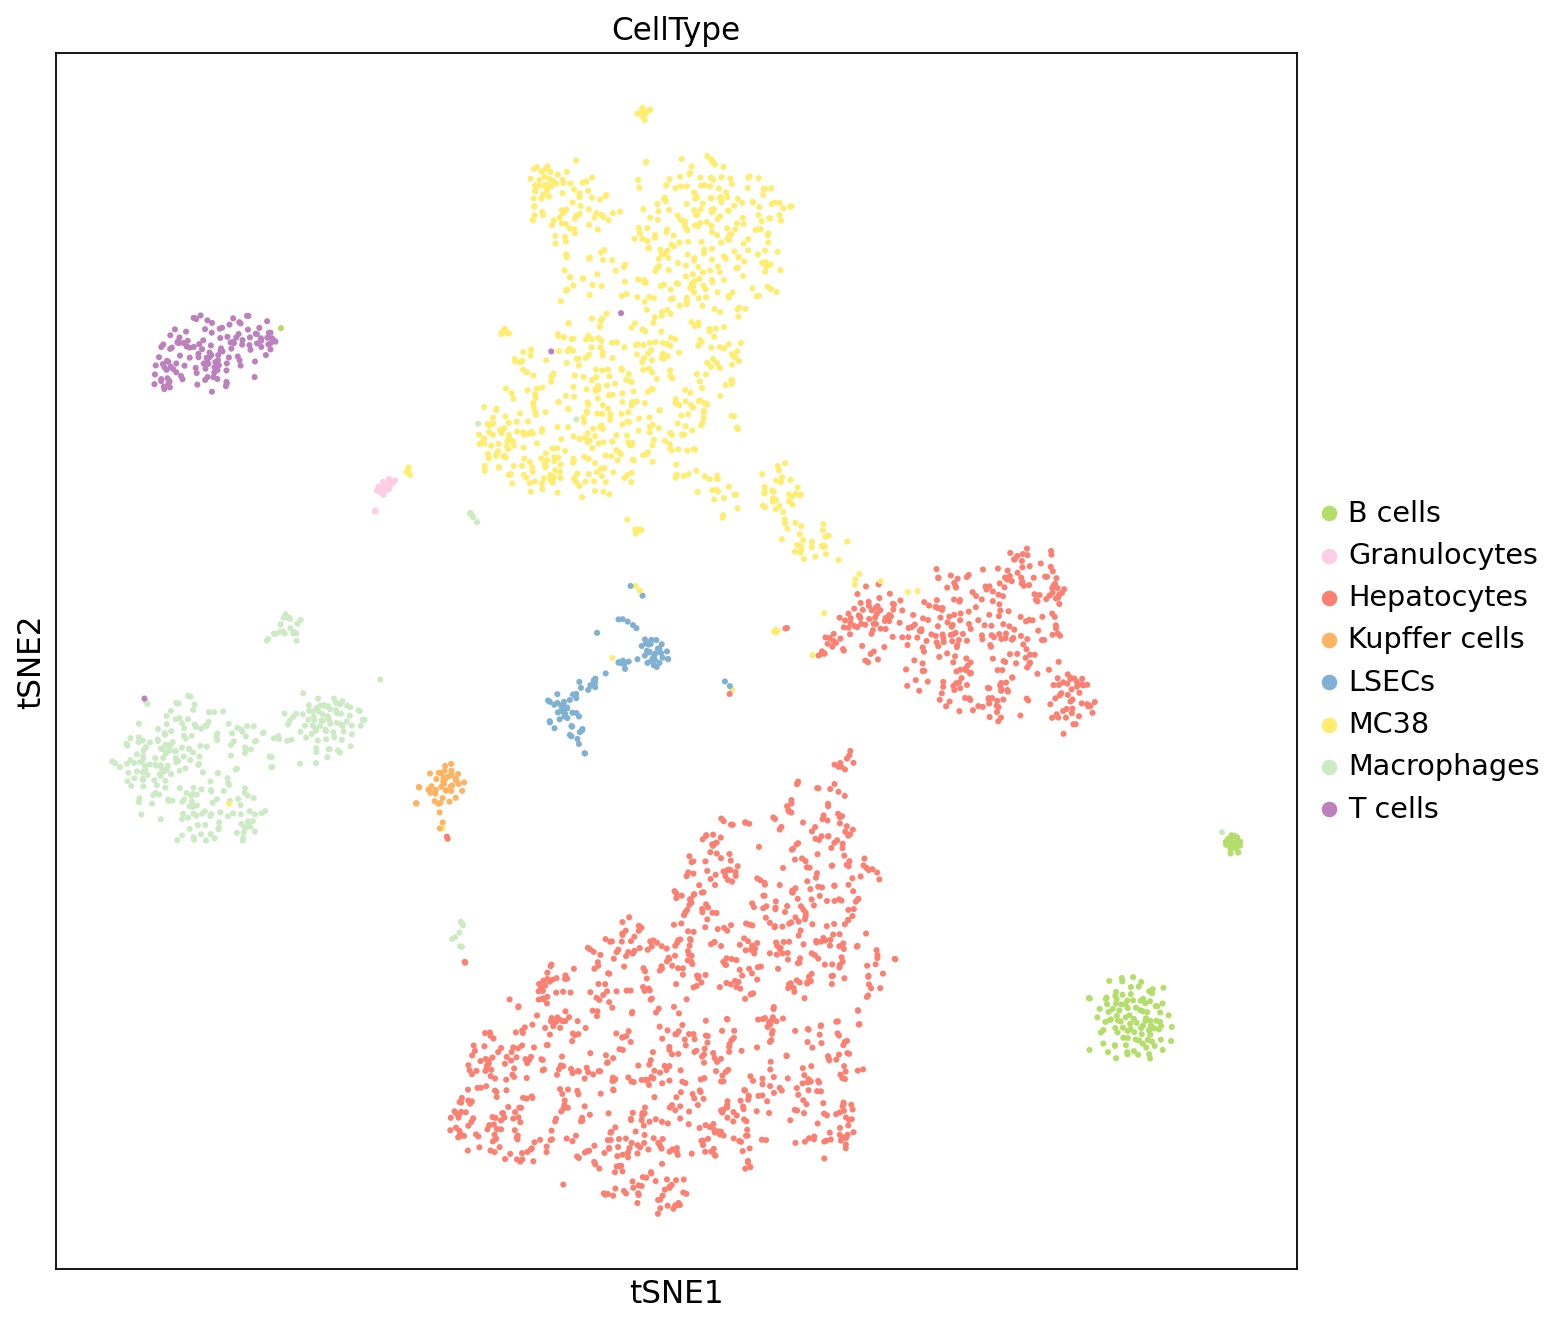

In [44]:
fig, ax = plt.subplots(1,1,figsize=(10, 8.5))
sc.pl.tsne(data['adata_mouse'],color=['CellType'], size=30, ax=ax, return_fig=False, show=False)
plt.tight_layout()
# plt.savefig(prefix + '10x/2020112/figures2/10x.mouse.tsne.svg')

### Cell Type Correlations

Code taken from https://github.com/yelabucsf/lupus_1M_cells_clean/blob/master/figure6_flare/Figure6Flare.V6.ipynb

In [45]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """A function go get mean z-score expressions of marker genes
    #
    # Inputs:
    #    anndata        - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                   an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                   genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                   'louvain_r1' """

    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

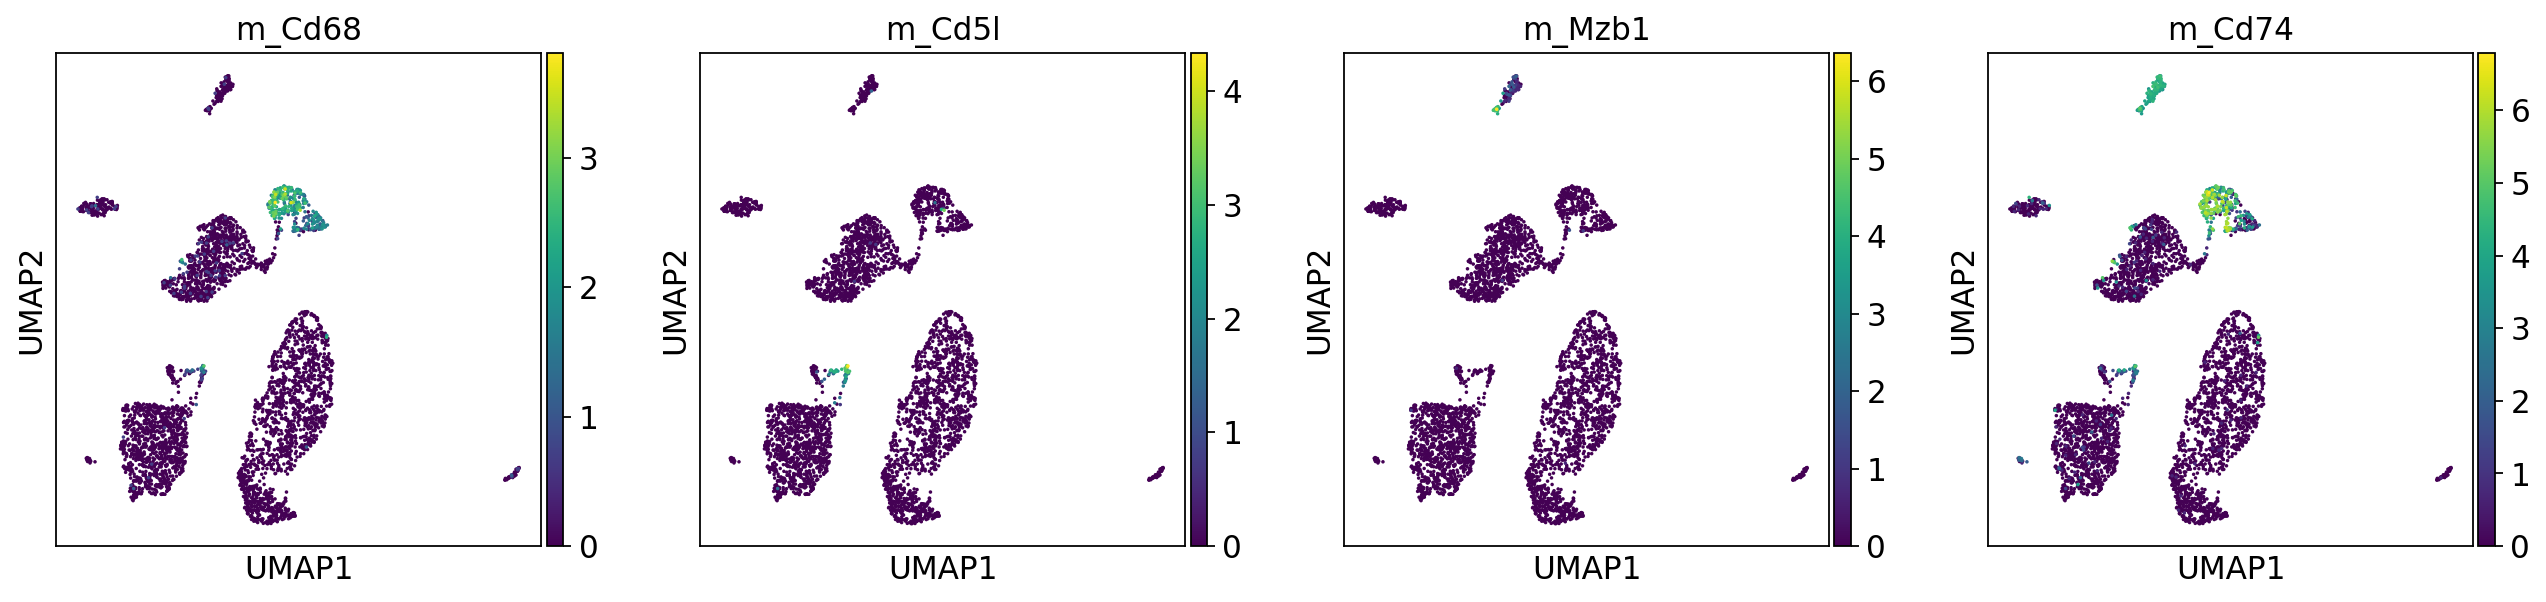

In [46]:
sc.pl.umap(data['adata'],color=['m_Cd68', 'm_Cd5l', 'm_Mzb1', 'm_Cd74'], size=10)

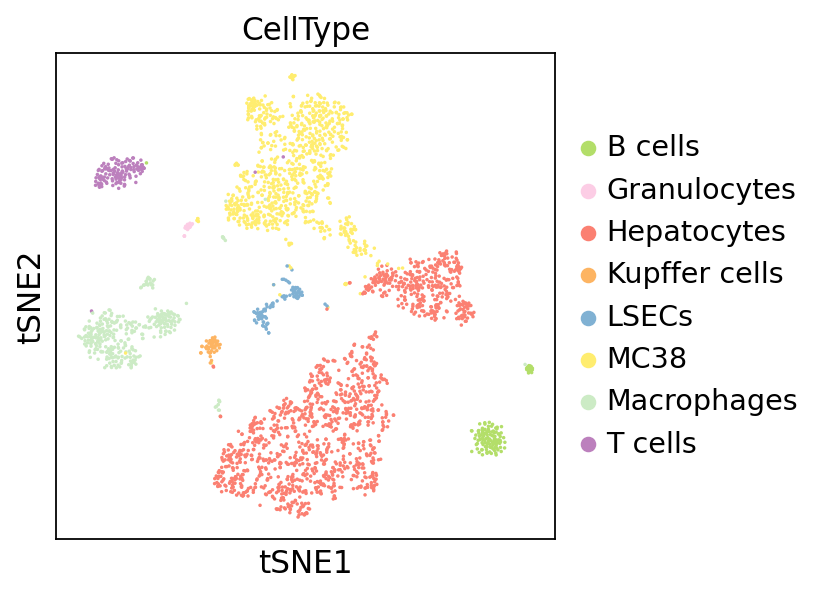

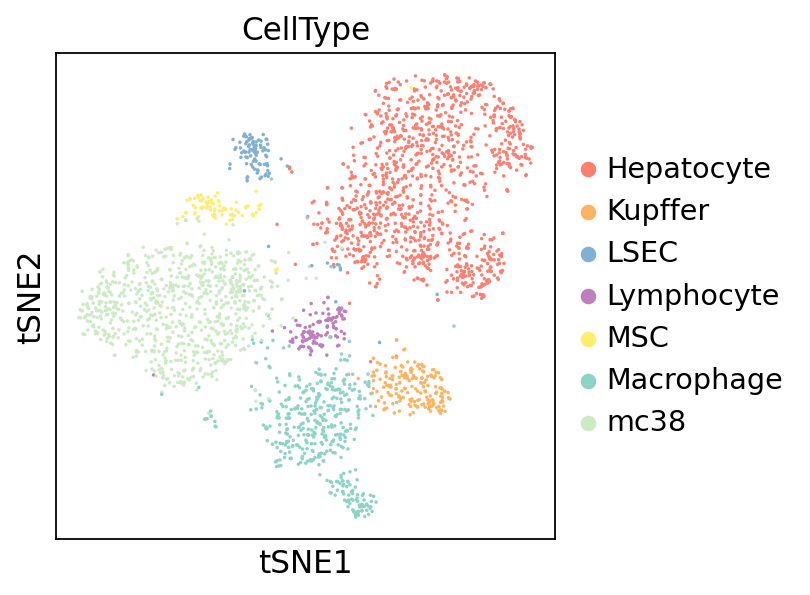

In [47]:
sc.pl.tsne(data['adata_mouse'],color=['CellType'], size=10)
sc.pl.tsne(l20c1,color=['CellType'], size=10)

In [48]:
names, counts = np.unique(l20c1.obs['CellType'], return_counts=True)
for i in range(len(names)):
    print(names[i] + ": " + str(counts[i]/len(l20c1))[:5])

Hepatocyte: 0.405
Kupffer: 0.062
LSEC: 0.035
Lymphocyte: 0.040
MSC: 0.028
Macrophage: 0.150
mc38: 0.276


### Correlate proportion in each Leiden cluster

In [67]:
ct_props = dict()

In [68]:
ct_props['xyzeq'] = dict()
ct_props['10x'] = dict()

ct_props['xyzeq']['cts'], ct_props['xyzeq']['counts'] = np.unique(l20c1.obs['CellType'].values,return_counts=True)
ct_props['xyzeq']['props'] = np.apply_along_axis(lambda x: x/ct_props['xyzeq']['counts'].sum(), 0, arr=ct_props['xyzeq']['counts'])

ct_props['10x']['cts'], ct_props['10x']['counts'] = np.unique(data['adata_mouse'].obs['CellType'].values,return_counts=True)
ct_props['10x']['props'] = np.apply_along_axis(lambda x: x/ct_props['10x']['counts'].sum(), 0, arr=ct_props['10x']['counts'])

ct_props['xyzeq']['dict'] = dict(zip(ct_props['xyzeq']['cts'], ct_props['xyzeq']['props']))
ct_props['10x']['dict'] = dict(zip(ct_props['10x']['cts'], ct_props['10x']['props']))

In [69]:
ct_props['xyzeq']['dict']

{'Hepatocyte': 0.4059993024066969,
 'Kupffer': 0.06278339727938612,
 'LSEC': 0.035926055109870944,
 'Lymphocyte': 0.040111614928496686,
 'MSC': 0.0286013254272759,
 'Macrophage': 0.15033135681897453,
 'mc38': 0.27624694802929894}

In [70]:
ct_props['10x']['dict']

{'B cells': 0.0413142485361093,
 'Granulocytes': 0.0068314899154196486,
 'Hepatocytes': 0.4642160052049447,
 'Kupffer cells': 0.014638906961613532,
 'LSECs': 0.03188028627195836,
 'MC38': 0.28464541314248537,
 'Macrophages': 0.11190631099544568,
 'T cells': 0.044567338972023425}

In [73]:
groups = data['adata'].obs['leiden'].unique()

In [74]:
compare = {'Hepatocytes':'Hepatocytes',
           'LSECs':'LSECs',
           'Macrophages':'Macrophages',
           'MC38':'MC38',
           'Kupffer cells':'Kupffer cells',
           'Lymphocytes':'T cells',
          }

In [75]:
corr_colors = [colors['coral'], 
               colors['blue'],
               colors['mint'],
               colors['dark yel'],
               colors['orange'],
               colors['purp'],
              ]

In [77]:
group_counts = list()
for group in groups: # groups defined earlier
    batches = data['adata'][data['adata'].obs['leiden'] == group].obs['batch'].values
    vals, counts = np.unique(batches, return_counts=True)
    group_counts.append(counts)

AnnData object with n_obs × n_vars = 2867 × 744
    obs: 'CellType', 'barcode', 'cell_call', 'human_counts', 'leiden', 'log_counts', 'louvain', 'mouse_counts', 'n_counts', 'n_genes', 'percent_contam', 'percent_mito_human', 'percent_mito_mouse', 'ratio'
    var: 'log_cells', 'n_cells'
    uns: 'CellType_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [355]:
vals, batch_counts = np.unique(adata.obs['batch'].values, return_counts=True)

In [359]:
x = [ct_props['xyzeq']['dict'][x] for x in compare.keys()]
y = [ct_props['10x']['dict'][x] for x in compare.values()]
n = compare.keys()

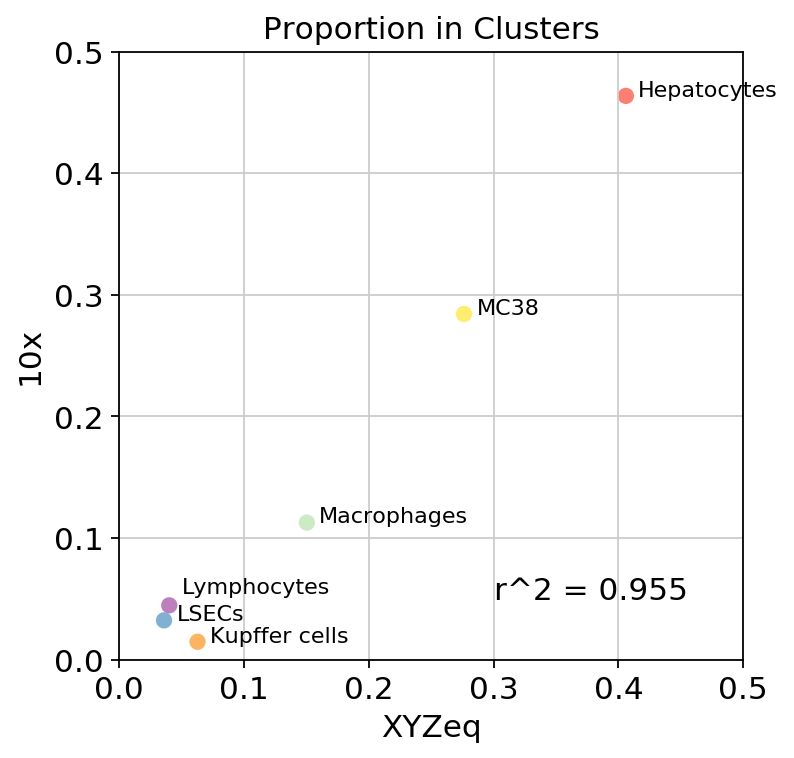

In [376]:
plt.figure(figsize=(5,5))
plt.scatter(x, y, color=corr_colors, s=40);
plt.title('Proportion in Clusters')
plt.xlabel('XYZeq')
plt.ylabel('10x')
plt.xlim(0,0.5)
plt.xticks(np.arange(0, 0.6, 0.1))
plt.ylim(0,0.5)
ax = plt.gca()
for i, txt in enumerate(n):
    if txt == 'Lymphocytes':
        ax.annotate(txt, (x[i]+0.01, y[i]+0.01), size=10)
    else:
        ax.annotate(txt, (x[i]+0.01, y[i]), size=10)

# The difference between correlation and coefficient of determination
# They can correlate, but that's not what I want to see. I want to see how well they fit the model that the proportions should be identical, x = y
# is the r2_score() command right then?

# r = pearsonr(x,y)[0]
r2 = r2_score(y_true=y, y_pred=x)

# plt.text(0.2, 0.01, 'pearsonr = ' + str(r)[:5]);
plt.text(0.3, 0.05, 'r^2 = ' + str(r2)[:5]);
plt.savefig(prefix + '10x/2020112/figures2/correlate.proportion.2.pdf')
plt.savefig(prefix + '10x/2020112/figures2/correlate.proportion.2.svg')